In [0]:
from google.colab import auth
auth.authenticate_user()

In [50]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [51]:
!ls /content/gdrive/My\ Drive/Datasets/Flight_Delay/

Flight_Delay.ipynb	flight_delays_train.csv
flight_delays_test.csv	README.md.gdoc


In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
%matplotlib inline
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
import os

import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
from scipy.stats import norm

pd.options.display.float_format = '{:.0f}'.format

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [53]:
!apt-get install software-properties-common 
!add-apt-repository -y ppa:alessandro-strada/ppa 
!apt-get update 
!apt-get -y install -qq google-drive-ocamlfuse fuse

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python3-software-properties
Recommended packages:
  unattended-upgrades
The following packages will be upgraded:
  python3-software-properties software-properties-common
2 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Need to get 32.0 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 software-properties-common all 0.96.24.32.6 [9,916 B]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 python3-software-properties all 0.96.24.32.6 [22.1 kB]
Fetched 32.0 kB in 1s (61.1 kB/s)
(Reading database ... 110382 files and directories currently installed.)
Preparing to unpack .../software-properties-common_0.96.24.32.6_all.deb ...
Unpacking software-properties-common (0.96.24.32.6) over (0.96.24.32.5) ...
Preparing to unpack

In [0]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [0]:
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

In [57]:
vcode = getpass.getpass()

··········


In [0]:
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [59]:
!mkdir -p mydrive
!google-drive-ocamlfuse mydrive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [60]:
!ls mydrive/Datasets/Flight_Delay/

Flight_Delay.ipynb	flight_delays_train.csv
flight_delays_test.csv	README.md.odt


In [0]:
train = pd.read_csv("mydrive/Datasets/Flight_Delay/flight_delays_train.csv")
test_df = pd.read_csv("mydrive/Datasets/Flight_Delay/flight_delays_test.csv")

In [62]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [63]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [64]:
train.shape, test_df.shape

((100000, 9), (100000, 8))

In [65]:
train.describe()

,DepTime,Distance
count,100000,100000
mean,1342,729
std,476,575
min,1,30
25%,931,317
50%,1330,575
75%,1733,957
max,2534,4962


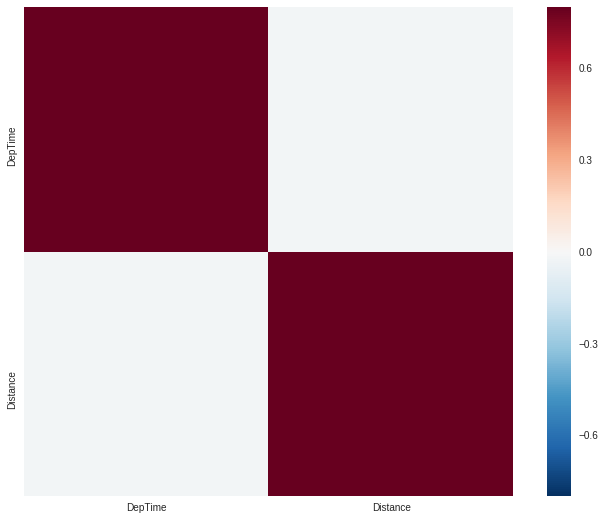

In [66]:
# Correlation matrix
corr_mat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);
plt.show()

In [67]:
test_df.describe()

,DepTime,Distance
count,100000,100000
mean,1339,723
std,481,563
min,1,31
25%,928,321
50%,1329,574
75%,1733,948
max,2400,4962


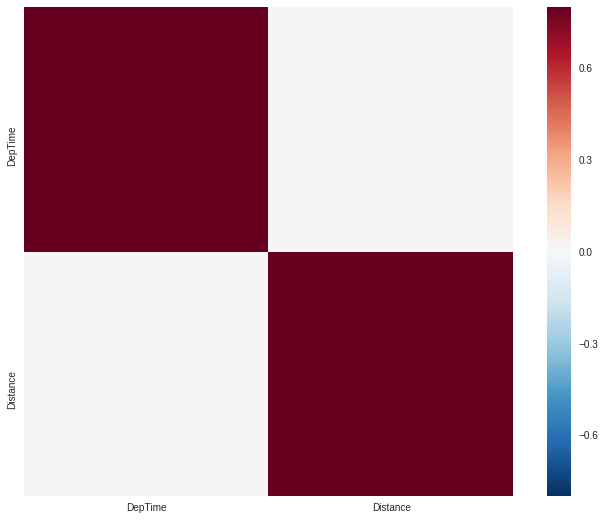

In [68]:
# Correlation matrix
corr_mat = test_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);
plt.show()

# LightGBM Baseline

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [70]:
!pip install lightgbm

In [0]:
import lightgbm as lgb

In [0]:
train['DayOfWeek'] = train.DayOfWeek.apply(lambda x: int(x.split('-')[1]))
train['Month'] = train.Month.apply(lambda x: int(x.split('-')[1]))
train['DayofMonth'] = train.DayofMonth.apply(lambda x: int(x.split('-')[1]))

train['dep_delayed_15min'] = train.dep_delayed_15min.apply(lambda x: 1 if x == 'Y' else 0)

origin_list = train.Origin.value_counts().head(10).index.tolist()
train['Origin'] = train.Origin.apply(lambda x: x if x in origin_list else 'other')

dest_list = train.Dest.value_counts().head(10).index.tolist()
train['Dest'] = train.Dest.apply(lambda x: x if x in dest_list else 'other')

carriers_list = train.UniqueCarrier.value_counts().head(10).index.tolist()
train['UniqueCarrier'] = train.UniqueCarrier.apply(lambda x: x if x in carriers_list else 'other')

train = pd.get_dummies(train)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['dep_delayed_15min'],axis=1), train.dep_delayed_15min, 
                                                    test_size=0.33, random_state=99, stratify=train.dep_delayed_15min)

clf = RandomForestClassifier(n_estimators=100, max_depth=10)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.8107272727272727


In [74]:
print(confusion_matrix(y_pred, y_test))

[[26711  6242]
 [    4    43]]


In [75]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.7229797632602364

In [78]:
gbm = lgb.LGBMClassifier(n_estimators=200,)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

[1]	valid_0's binary_logloss: 0.478424	valid_0's l1: 0.30563
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.471939	valid_0's l1: 0.303198
[3]	valid_0's binary_logloss: 0.466567	valid_0's l1: 0.300933
[4]	valid_0's binary_logloss: 0.462277	valid_0's l1: 0.298907
[5]	valid_0's binary_logloss: 0.458583	valid_0's l1: 0.297018
[6]	valid_0's binary_logloss: 0.45535	valid_0's l1: 0.295265
[7]	valid_0's binary_logloss: 0.452557	valid_0's l1: 0.293672
[8]	valid_0's binary_logloss: 0.450311	valid_0's l1: 0.292247
[9]	valid_0's binary_logloss: 0.448336	valid_0's l1: 0.290949
[10]	valid_0's binary_logloss: 0.446712	valid_0's l1: 0.289749
[11]	valid_0's binary_logloss: 0.445081	valid_0's l1: 0.288536
[12]	valid_0's binary_logloss: 0.443788	valid_0's l1: 0.287486
[13]	valid_0's binary_logloss: 0.442516	valid_0's l1: 0.286572
[14]	valid_0's binary_logloss: 0.441434	valid_0's l1: 0.285605
[15]	valid_0's binary_logloss: 0.4406	valid_0's l1: 0.28488
[16]	val

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3,
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Parametrization for GS
gridParams = {
    'learning_rate': [0.5, 0.005],
    'n_estimators': [40, 200, 1000],
    'num_leaves': [5, 10, 15],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [99], 
    'colsample_bytree' : [0.66],
    'subsample' : [0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.4],
    }

# Classifier
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'auc',
          n_jobs = 3, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [80]:
grid = GridSearchCV(mdl, gridParams,
                    verbose=3,
                    cv=4,
                    n_jobs=2)
# Grid Search on the go!
grid.fit(train.drop('dep_delayed_15min', axis=1), train.dep_delayed_15min)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   14.7s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 19.7min
[Parallel(n_jobs=2)]: Done 288 out of 288 | elapsed: 20.6min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_bin=512,
        max_depth=-1, min_child_samples=5, min_child_weight=1,
        min_split_gain=0.5, n_estimators=100, n_jobs=3, num_leaves=31,
        objective='auc', random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=1, silent=True, subsample=1,
        subsample_for_bin=200, subsample_freq=1),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'learning_rate': [0.5, 0.005], 'n_estimators': [40, 200, 1000], 'num_leaves': [5, 10, 15], 'boosting_type': ['gbdt'], 'objective': ['binary'], 'random_state': [99], 'colsample_bytree': [0.66], 'subsample': [0.75], 'reg_alpha': [1, 1.2], 'reg_lambda': [1, 1.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [81]:
grid.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.66,
 'learning_rate': 0.5,
 'n_estimators': 1000,
 'num_leaves': 5,
 'objective': 'binary',
 'random_state': 99,
 'reg_alpha': 1,
 'reg_lambda': 1.4,
 'subsample': 0.75}

In [82]:
gbm = lgb.LGBMClassifier(**grid.best_params_)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

[1]	valid_0's binary_logloss: 0.462333	valid_0's l1: 0.300706
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.454136	valid_0's l1: 0.294929
[3]	valid_0's binary_logloss: 0.450107	valid_0's l1: 0.290699
[4]	valid_0's binary_logloss: 0.449015	valid_0's l1: 0.289551
[5]	valid_0's binary_logloss: 0.447447	valid_0's l1: 0.288527
[6]	valid_0's binary_logloss: 0.445181	valid_0's l1: 0.286951
[7]	valid_0's binary_logloss: 0.443318	valid_0's l1: 0.285177
[8]	valid_0's binary_logloss: 0.442301	valid_0's l1: 0.284481
[9]	valid_0's binary_logloss: 0.441084	valid_0's l1: 0.283665
[10]	valid_0's binary_logloss: 0.440184	valid_0's l1: 0.28282
[11]	valid_0's binary_logloss: 0.439546	valid_0's l1: 0.28227
[12]	valid_0's binary_logloss: 0.438955	valid_0's l1: 0.281784
[13]	valid_0's binary_logloss: 0.438446	valid_0's l1: 0.281245
[14]	valid_0's binary_logloss: 0.438154	valid_0's l1: 0.280664
[15]	valid_0's binary_logloss: 0.437445	valid_0's l1: 0.279995
[16]	

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
        importance_type='split', learning_rate=0.5, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=5, objective='binary',
        random_state=99, reg_alpha=1, reg_lambda=1.4, silent=True,
        subsample=0.75, subsample_for_bin=200000, subsample_freq=0)

In [83]:
gbm = lgb.LGBMClassifier(**grid.best_params_)
gbm.fit(train.drop('dep_delayed_15min', axis=1), train.dep_delayed_15min)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.66,
        importance_type='split', learning_rate=0.5, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=5, objective='binary',
        random_state=99, reg_alpha=1, reg_lambda=1.4, silent=True,
        subsample=0.75, subsample_for_bin=200000, subsample_freq=0)

In [84]:
roc_auc_score(y_test, gbm.predict_proba(X_test)[:, 1])

0.8137073243290689

In [0]:
test_df['DayOfWeek'] = test_df.DayOfWeek.apply(lambda x: int(x.split('-')[1]))
test_df['Month'] = test_df.Month.apply(lambda x: int(x.split('-')[1]))
test_df['DayofMonth'] = test_df.DayofMonth.apply(lambda x: int(x.split('-')[1]))

test_df['Origin'] = test_df.Origin.apply(lambda x: x if x in origin_list else 'other')
test_df['Dest'] = test_df.Dest.apply(lambda x: x if x in dest_list else 'other')
test_df['UniqueCarrier'] = test_df.UniqueCarrier.apply(lambda x: x if x in carriers_list else 'other')

test_df = pd.get_dummies(test)